<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/Transfer%20Learning/Transfer_Learning_Fine_Tuning_Flower_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tdfs
import pandas as pd
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-25 16:02:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-25 16:02:08 (70.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import plot_loss_curves,walk_through_dir

In [4]:
import tensorflow_datasets as tfds
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 11s 0us/step


In [41]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(data_dir,image_size = (224,224),batch_size = 32,subset = "training",validation_split = 0.2,seed = 42,label_mode = "categorical",shuffle = True)
test_data = image_dataset_from_directory(data_dir,image_size = (224,224),batch_size = 32,subset = "validation",validation_split = 0.2,seed = 42,label_mode = "categorical",shuffle = True)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Visualizing Data

In [6]:
def load_and_prep_image(filename,img_shape=224):
  """Reads an image from filename and preprocess it to tensor and reshapes it to (img_shape,img_shape,color channels)"""
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img,[img_shape,img_shape])
  img = img/255.
  return img

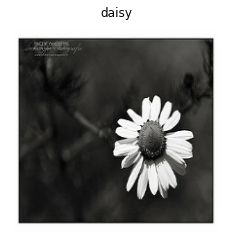

In [42]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_random_image(class_names,data_dir):
  class_name = random.choice(class_names)
  directory = str(data_dir)+'/'+class_name
  img = str(random.sample(os.listdir(directory),1)[-1])
  img = load_and_prep_image(directory+'/'+img)
  plt.imshow(img)
  plt.axis(False)
  plt.title(class_name)
class_names = train_data.class_names
plot_random_image(class_names,data_dir)

## Data Augmentation Layers and Checkpoint layers

In [8]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
])
checkpoint_path_efficient_net = "efficient_net_checkpoint/checkpoint_base.ckpt"
efficient_net_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath =checkpoint_path_efficient_net,
    save_best_only = True,
    save_weights_only = True,
    save_freq = "epoch"
    )

## Backbone Model EfficientNetB6

In [43]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB6(include_top = False)
base_model.trainable = False

#Input Layers
inputs = tf.keras.layers.Input(shape = input_shape,name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)

x = tf.keras.layers.GlobalAveragePooling2D(name = "pooling_layer")(x)

outputs = tf.keras.layers.Dense(5,activation = "softmax",name = "output_layer")(x)

model_0 = tf.keras.Model(inputs,outputs)
model_0.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])


In [44]:
model_0.fit(
    train_data,epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.25*(len(test_data))),
    callbacks = [efficient_net_checkpoint],
    batch_size = 32
)

Epoch 1/5
92/92 [==============================] - 61s 501ms/step - loss: 0.7960 - accuracy: 0.7258 - val_loss: 0.4866 - val_accuracy: 0.8687
Epoch 2/5
92/92 [==============================] - 42s 455ms/step - loss: 0.5031 - accuracy: 0.8225 - val_loss: 0.5438 - val_accuracy: 0.8000
Epoch 3/5
92/92 [==============================] - 45s 486ms/step - loss: 0.4273 - accuracy: 0.8529 - val_loss: 0.4502 - val_accuracy: 0.8625
Epoch 4/5
92/92 [==============================] - 43s 462ms/step - loss: 0.3800 - accuracy: 0.8709 - val_loss: 0.3405 - val_accuracy: 0.9000
Epoch 5/5
92/92 [==============================] - 42s 450ms/step - loss: 0.3627 - accuracy: 0.8770 - val_loss: 0.2682 - val_accuracy: 0.9062


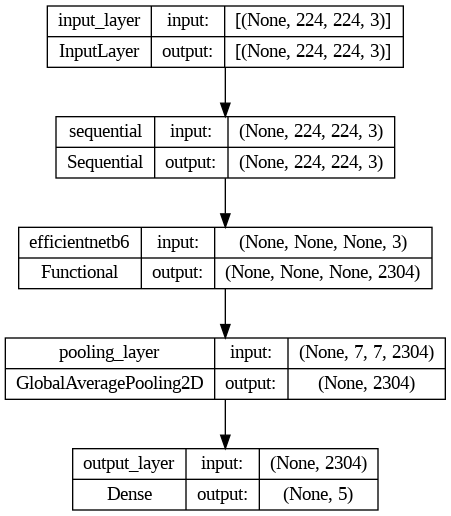

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model_0,show_shapes = True)

In [12]:
base_model.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

## Fine Tuning Base Model

In [45]:
model_0.load_weights(checkpoint_path_efficient_net)

In [46]:
base_model.trainable = True

for layer in base_model.layers[:-15]:
  layer.trainable = False
model_0.compile(loss = "categorical_crossentropy",optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),metrics = ["accuracy"])
     

In [47]:
fine_tune_epochs = 10
history_1 = model_0.fit(
            train_data,
            epochs = fine_tune_epochs,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = int(0.25*(len(test_data))),
            initial_epoch = 5,
    )

Epoch 6/10
92/92 [==============================] - 64s 528ms/step - loss: 0.3241 - accuracy: 0.8815 - val_loss: 0.2609 - val_accuracy: 0.8875
Epoch 7/10
92/92 [==============================] - 44s 473ms/step - loss: 0.2686 - accuracy: 0.9036 - val_loss: 0.3273 - val_accuracy: 0.8938
Epoch 8/10
92/92 [==============================] - 43s 465ms/step - loss: 0.2203 - accuracy: 0.9203 - val_loss: 0.2477 - val_accuracy: 0.9125
Epoch 9/10
92/92 [==============================] - 41s 442ms/step - loss: 0.2078 - accuracy: 0.9237 - val_loss: 0.2073 - val_accuracy: 0.9187
Epoch 10/10
92/92 [==============================] - 42s 450ms/step - loss: 0.1960 - accuracy: 0.9305 - val_loss: 0.2428 - val_accuracy: 0.9125


In [48]:
model_0.evaluate(test_data)

23/23 [==============================] - 7s 270ms/step - loss: 0.2981 - accuracy: 0.8937


[0.29813632369041443, 0.8937329649925232]

In [53]:
def pred_and_plot(model,class_names=class_names):
  """Imports an image located at filename, make a prediction with model and plots the image with predicted class as the title"""
  class_name = random.choice(class_names)
  directory = str(data_dir)+'/'+class_name
  img = str(random.sample(os.listdir(directory),1)[-1])
  img = load_and_prep_image(directory+'/'+img)
  pred = model.predict(tf.expand_dims(img,axis=0))
  print(pred[0])
  print(class_names)
  if len(pred[0])>1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred))]
  plt.imshow(img)
  if(pred_class == class_name):
    color = 'green'
  else:
    color = 'red'
  plt.title("Prediction: "+pred_class,color = color)
  plt.axis(False);
     

1/1 [==============================] - 0s 41ms/step
[0.1228476  0.15520966 0.65363514 0.05226237 0.01604515]
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


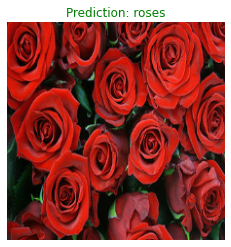

In [68]:
pred_and_plot(model_0,class_names)